<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=632e5e670e6e5e046d6ca056a7ce7ff8355d1123d416e7ee1aa2e65d39fde167
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=2f8f2039a12523fffc08a21f5c398ed7f0dde16017c7b708e9e789bcc96c310b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 19.7MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [34]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 100
    batch_size = 16
    learning_rate = 1e-3
    momentum = 0.9
    weight_decay = 1e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [35]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [36]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [7]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [8]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [37]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=3)
        self.bottleneck2 = Bottleneck(512, num_layers=3)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#6. Training and testing

In [45]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 50:
        return 0.3
    elif 50 <= epoch < 70:
        return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)

class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        return self.weight_bce * bce_loss + self.weight_dice * dice_loss
# BCE + DICE
criterion = CombinedLoss(weight_bce=0.2, weight_dice=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [46]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/100 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch 1/100, Training Loss: 0.1409


Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 1/100, Validation Loss: 0.7275
Precision: 0.7344, Recall: 0.9233, Accuracy: 0.8685
IoU: 0.6906, F1 Score: 0.8181, Dice Coefficient: 0.8139
Pixel Error: 0.1315, Rand Error: 0.4582


Epoch 2/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 2/100, Training Loss: 0.1040


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 2/100, Validation Loss: 0.1161
Precision: 0.9273, Recall: 0.9321, Accuracy: 0.9548
IoU: 0.8635, F1 Score: 0.9297, Dice Coefficient: 0.9263
Pixel Error: 0.0452, Rand Error: 0.1789


Epoch 3/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 3/100, Training Loss: 0.0767


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Epoch 3/100, Validation Loss: 0.0920
Precision: 0.9457, Recall: 0.9369, Accuracy: 0.9626
IoU: 0.8867, F1 Score: 0.9413, Dice Coefficient: 0.9396
Pixel Error: 0.0374, Rand Error: 0.1487


Epoch 4/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 4/100, Training Loss: 0.0590


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Epoch 4/100, Validation Loss: 0.0940
Precision: 0.9249, Recall: 0.9566, Accuracy: 0.9612
IoU: 0.8852, F1 Score: 0.9405, Dice Coefficient: 0.9389
Pixel Error: 0.0388, Rand Error: 0.1525


Epoch 5/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 5/100, Training Loss: 0.0721


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


Epoch 5/100, Validation Loss: 0.1005
Precision: 0.9431, Recall: 0.9297, Accuracy: 0.9595
IoU: 0.8837, F1 Score: 0.9364, Dice Coefficient: 0.9381
Pixel Error: 0.0405, Rand Error: 0.1571


Epoch 6/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 6/100, Training Loss: 0.0645


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 6/100, Validation Loss: 0.1022
Precision: 0.9121, Recall: 0.9584, Accuracy: 0.9571
IoU: 0.8786, F1 Score: 0.9347, Dice Coefficient: 0.9353
Pixel Error: 0.0429, Rand Error: 0.1662


Epoch 7/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 7/100, Training Loss: 0.0650


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 7/100, Validation Loss: 0.1097
Precision: 0.9489, Recall: 0.9171, Accuracy: 0.9577
IoU: 0.8715, F1 Score: 0.9328, Dice Coefficient: 0.9309
Pixel Error: 0.0423, Rand Error: 0.1673


Epoch 8/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 8/100, Training Loss: 0.0592


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 8/100, Validation Loss: 0.0995
Precision: 0.9419, Recall: 0.9360, Accuracy: 0.9610
IoU: 0.8820, F1 Score: 0.9389, Dice Coefficient: 0.9370
Pixel Error: 0.0390, Rand Error: 0.1537


Epoch 9/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 9/100, Training Loss: 0.0511


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 9/100, Validation Loss: 0.0857
Precision: 0.9665, Recall: 0.9239, Accuracy: 0.9654
IoU: 0.8971, F1 Score: 0.9447, Dice Coefficient: 0.9455
Pixel Error: 0.0346, Rand Error: 0.1359


Epoch 10/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 10/100, Training Loss: 0.0733


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 10/100, Validation Loss: 0.2861
Precision: 0.9869, Recall: 0.7135, Accuracy: 0.9052
IoU: 0.7067, F1 Score: 0.8282, Dice Coefficient: 0.8276
Pixel Error: 0.0948, Rand Error: 0.3571


Epoch 11/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 11/100, Training Loss: 0.1174


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 11/100, Validation Loss: 0.1351
Precision: 0.9252, Recall: 0.9122, Accuracy: 0.9483
IoU: 0.8506, F1 Score: 0.9186, Dice Coefficient: 0.9182
Pixel Error: 0.0517, Rand Error: 0.2007


Epoch 12/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 12/100, Training Loss: 0.0841


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 12/100, Validation Loss: 0.1002
Precision: 0.9524, Recall: 0.9199, Accuracy: 0.9596
IoU: 0.8781, F1 Score: 0.9359, Dice Coefficient: 0.9343
Pixel Error: 0.0404, Rand Error: 0.1599


Epoch 13/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 13/100, Training Loss: 0.0687


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 13/100, Validation Loss: 0.1074
Precision: 0.9535, Recall: 0.9133, Accuracy: 0.9580
IoU: 0.8708, F1 Score: 0.9330, Dice Coefficient: 0.9302
Pixel Error: 0.0420, Rand Error: 0.1663


Epoch 14/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 14/100, Training Loss: 0.0556


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 14/100, Validation Loss: 0.0828
Precision: 0.9462, Recall: 0.9492, Accuracy: 0.9665
IoU: 0.9002, F1 Score: 0.9477, Dice Coefficient: 0.9473
Pixel Error: 0.0335, Rand Error: 0.1323


Epoch 15/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 15/100, Training Loss: 0.0411


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 15/100, Validation Loss: 0.0777
Precision: 0.9457, Recall: 0.9561, Accuracy: 0.9684
IoU: 0.9063, F1 Score: 0.9509, Dice Coefficient: 0.9507
Pixel Error: 0.0316, Rand Error: 0.1244


Epoch 16/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 16/100, Training Loss: 0.0414


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.83s/it]


Epoch 16/100, Validation Loss: 0.0711
Precision: 0.9591, Recall: 0.9486, Accuracy: 0.9706
IoU: 0.9134, F1 Score: 0.9538, Dice Coefficient: 0.9546
Pixel Error: 0.0294, Rand Error: 0.1157


Epoch 17/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 17/100, Training Loss: 0.0368


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 17/100, Validation Loss: 0.0695
Precision: 0.9552, Recall: 0.9548, Accuracy: 0.9712
IoU: 0.9155, F1 Score: 0.9550, Dice Coefficient: 0.9557
Pixel Error: 0.0288, Rand Error: 0.1132


Epoch 18/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 18/100, Training Loss: 0.0328


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 18/100, Validation Loss: 0.0644
Precision: 0.9527, Recall: 0.9648, Accuracy: 0.9734
IoU: 0.9212, F1 Score: 0.9587, Dice Coefficient: 0.9589
Pixel Error: 0.0266, Rand Error: 0.1051


Epoch 19/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 19/100, Training Loss: 0.0303


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 19/100, Validation Loss: 0.0651
Precision: 0.9619, Recall: 0.9537, Accuracy: 0.9731
IoU: 0.9218, F1 Score: 0.9578, Dice Coefficient: 0.9591
Pixel Error: 0.0269, Rand Error: 0.1055


Epoch 20/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 20/100, Training Loss: 0.0297


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 20/100, Validation Loss: 0.0677
Precision: 0.9438, Recall: 0.9707, Accuracy: 0.9721
IoU: 0.9185, F1 Score: 0.9571, Dice Coefficient: 0.9573
Pixel Error: 0.0279, Rand Error: 0.1096


Epoch 21/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 21/100, Training Loss: 0.0274


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 21/100, Validation Loss: 0.0693
Precision: 0.9547, Recall: 0.9563, Accuracy: 0.9715
IoU: 0.9168, F1 Score: 0.9555, Dice Coefficient: 0.9564
Pixel Error: 0.0285, Rand Error: 0.1117


Epoch 22/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 22/100, Training Loss: 0.0287


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 22/100, Validation Loss: 0.0634
Precision: 0.9483, Recall: 0.9706, Accuracy: 0.9736
IoU: 0.9219, F1 Score: 0.9593, Dice Coefficient: 0.9592
Pixel Error: 0.0264, Rand Error: 0.1041


Epoch 23/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 23/100, Training Loss: 0.0274


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 23/100, Validation Loss: 0.0626
Precision: 0.9496, Recall: 0.9694, Accuracy: 0.9737
IoU: 0.9224, F1 Score: 0.9594, Dice Coefficient: 0.9595
Pixel Error: 0.0263, Rand Error: 0.1038


Epoch 24/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 24/100, Training Loss: 0.0282


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 24/100, Validation Loss: 0.0722
Precision: 0.9553, Recall: 0.9526, Accuracy: 0.9706
IoU: 0.9147, F1 Score: 0.9539, Dice Coefficient: 0.9552
Pixel Error: 0.0294, Rand Error: 0.1149


Epoch 25/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 25/100, Training Loss: 0.0262


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 25/100, Validation Loss: 0.0685
Precision: 0.9580, Recall: 0.9548, Accuracy: 0.9721
IoU: 0.9172, F1 Score: 0.9564, Dice Coefficient: 0.9567
Pixel Error: 0.0279, Rand Error: 0.1097


Epoch 26/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 26/100, Training Loss: 0.0272


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 26/100, Validation Loss: 0.0687
Precision: 0.9525, Recall: 0.9612, Accuracy: 0.9722
IoU: 0.9178, F1 Score: 0.9568, Dice Coefficient: 0.9569
Pixel Error: 0.0278, Rand Error: 0.1091


Epoch 27/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 27/100, Training Loss: 0.0251


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 27/100, Validation Loss: 0.0661
Precision: 0.9587, Recall: 0.9570, Accuracy: 0.9730
IoU: 0.9195, F1 Score: 0.9579, Dice Coefficient: 0.9578
Pixel Error: 0.0270, Rand Error: 0.1064


Epoch 28/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 28/100, Training Loss: 0.0257


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 28/100, Validation Loss: 0.0664
Precision: 0.9565, Recall: 0.9587, Accuracy: 0.9728
IoU: 0.9197, F1 Score: 0.9576, Dice Coefficient: 0.9580
Pixel Error: 0.0272, Rand Error: 0.1068


Epoch 29/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 29/100, Training Loss: 0.0247


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 29/100, Validation Loss: 0.0658
Precision: 0.9570, Recall: 0.9590, Accuracy: 0.9731
IoU: 0.9197, F1 Score: 0.9580, Dice Coefficient: 0.9580
Pixel Error: 0.0269, Rand Error: 0.1064


Epoch 30/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 30/100, Training Loss: 0.0243


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 30/100, Validation Loss: 0.0624
Precision: 0.9517, Recall: 0.9697, Accuracy: 0.9745
IoU: 0.9240, F1 Score: 0.9606, Dice Coefficient: 0.9604
Pixel Error: 0.0255, Rand Error: 0.1007


Epoch 31/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 31/100, Training Loss: 0.0243


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 31/100, Validation Loss: 0.0637
Precision: 0.9582, Recall: 0.9615, Accuracy: 0.9743
IoU: 0.9235, F1 Score: 0.9599, Dice Coefficient: 0.9601
Pixel Error: 0.0257, Rand Error: 0.1016


Epoch 32/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 32/100, Training Loss: 0.0241


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 32/100, Validation Loss: 0.0657
Precision: 0.9538, Recall: 0.9637, Accuracy: 0.9734
IoU: 0.9210, F1 Score: 0.9587, Dice Coefficient: 0.9587
Pixel Error: 0.0266, Rand Error: 0.1048


Epoch 33/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 33/100, Training Loss: 0.0238


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 33/100, Validation Loss: 0.0657
Precision: 0.9549, Recall: 0.9622, Accuracy: 0.9733
IoU: 0.9210, F1 Score: 0.9585, Dice Coefficient: 0.9587
Pixel Error: 0.0267, Rand Error: 0.1050


Epoch 34/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 34/100, Training Loss: 0.0237


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Epoch 34/100, Validation Loss: 0.0654
Precision: 0.9523, Recall: 0.9650, Accuracy: 0.9733
IoU: 0.9210, F1 Score: 0.9586, Dice Coefficient: 0.9587
Pixel Error: 0.0267, Rand Error: 0.1051


Epoch 35/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 35/100, Training Loss: 0.0230


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 35/100, Validation Loss: 0.0680
Precision: 0.9579, Recall: 0.9563, Accuracy: 0.9725
IoU: 0.9184, F1 Score: 0.9571, Dice Coefficient: 0.9573
Pixel Error: 0.0275, Rand Error: 0.1082


Epoch 36/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 36/100, Training Loss: 0.0232


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 36/100, Validation Loss: 0.0671
Precision: 0.9493, Recall: 0.9658, Accuracy: 0.9725
IoU: 0.9191, F1 Score: 0.9574, Dice Coefficient: 0.9577
Pixel Error: 0.0275, Rand Error: 0.1082


Epoch 37/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 37/100, Training Loss: 0.0233


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 37/100, Validation Loss: 0.0671
Precision: 0.9581, Recall: 0.9577, Accuracy: 0.9730
IoU: 0.9186, F1 Score: 0.9579, Dice Coefficient: 0.9574
Pixel Error: 0.0270, Rand Error: 0.1069


Epoch 38/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 38/100, Training Loss: 0.0249


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 38/100, Validation Loss: 0.0738
Precision: 0.9532, Recall: 0.9536, Accuracy: 0.9702
IoU: 0.9123, F1 Score: 0.9534, Dice Coefficient: 0.9539
Pixel Error: 0.0298, Rand Error: 0.1169


Epoch 39/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 39/100, Training Loss: 0.0225


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 39/100, Validation Loss: 0.0690
Precision: 0.9523, Recall: 0.9612, Accuracy: 0.9722
IoU: 0.9173, F1 Score: 0.9567, Dice Coefficient: 0.9567
Pixel Error: 0.0278, Rand Error: 0.1097


Epoch 40/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 40/100, Training Loss: 0.0227


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 40/100, Validation Loss: 0.0697
Precision: 0.9516, Recall: 0.9620, Accuracy: 0.9722
IoU: 0.9170, F1 Score: 0.9568, Dice Coefficient: 0.9565
Pixel Error: 0.0278, Rand Error: 0.1098


Epoch 41/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 41/100, Training Loss: 0.0238


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 41/100, Validation Loss: 0.0681
Precision: 0.9511, Recall: 0.9642, Accuracy: 0.9727
IoU: 0.9188, F1 Score: 0.9576, Dice Coefficient: 0.9575
Pixel Error: 0.0273, Rand Error: 0.1077


Epoch 42/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 42/100, Training Loss: 0.0231


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 42/100, Validation Loss: 0.0735
Precision: 0.9444, Recall: 0.9640, Accuracy: 0.9703
IoU: 0.9123, F1 Score: 0.9541, Dice Coefficient: 0.9540
Pixel Error: 0.0297, Rand Error: 0.1171


Epoch 43/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 43/100, Training Loss: 0.0230


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Epoch 43/100, Validation Loss: 0.0711
Precision: 0.9419, Recall: 0.9706, Accuracy: 0.9714
IoU: 0.9157, F1 Score: 0.9560, Dice Coefficient: 0.9558
Pixel Error: 0.0286, Rand Error: 0.1127


Epoch 44/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 44/100, Training Loss: 0.0228


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 44/100, Validation Loss: 0.0690
Precision: 0.9537, Recall: 0.9607, Accuracy: 0.9725
IoU: 0.9183, F1 Score: 0.9572, Dice Coefficient: 0.9572
Pixel Error: 0.0275, Rand Error: 0.1085


Epoch 45/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 45/100, Training Loss: 0.0221


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 45/100, Validation Loss: 0.0682
Precision: 0.9525, Recall: 0.9628, Accuracy: 0.9727
IoU: 0.9186, F1 Score: 0.9576, Dice Coefficient: 0.9574
Pixel Error: 0.0273, Rand Error: 0.1078


Epoch 46/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 46/100, Training Loss: 0.0216


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 46/100, Validation Loss: 0.0704
Precision: 0.9515, Recall: 0.9608, Accuracy: 0.9718
IoU: 0.9164, F1 Score: 0.9561, Dice Coefficient: 0.9561
Pixel Error: 0.0282, Rand Error: 0.1112


Epoch 47/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 47/100, Training Loss: 0.0216


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 47/100, Validation Loss: 0.0705
Precision: 0.9549, Recall: 0.9570, Accuracy: 0.9718
IoU: 0.9161, F1 Score: 0.9560, Dice Coefficient: 0.9560
Pixel Error: 0.0282, Rand Error: 0.1111


Epoch 48/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 48/100, Training Loss: 0.0223


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 48/100, Validation Loss: 0.0670
Precision: 0.9491, Recall: 0.9676, Accuracy: 0.9730
IoU: 0.9202, F1 Score: 0.9583, Dice Coefficient: 0.9582
Pixel Error: 0.0270, Rand Error: 0.1062


Epoch 49/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 49/100, Training Loss: 0.0218


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Epoch 49/100, Validation Loss: 0.0729
Precision: 0.9548, Recall: 0.9542, Accuracy: 0.9709
IoU: 0.9144, F1 Score: 0.9545, Dice Coefficient: 0.9551
Pixel Error: 0.0291, Rand Error: 0.1141


Epoch 50/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 50/100, Training Loss: 0.0211


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 50/100, Validation Loss: 0.0675
Precision: 0.9564, Recall: 0.9600, Accuracy: 0.9732
IoU: 0.9196, F1 Score: 0.9582, Dice Coefficient: 0.9580
Pixel Error: 0.0268, Rand Error: 0.1061


Epoch 51/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 51/100, Training Loss: 0.0214


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 51/100, Validation Loss: 0.0699
Precision: 0.9485, Recall: 0.9650, Accuracy: 0.9720
IoU: 0.9172, F1 Score: 0.9567, Dice Coefficient: 0.9566
Pixel Error: 0.0280, Rand Error: 0.1102


Epoch 52/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 52/100, Training Loss: 0.0216


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Epoch 52/100, Validation Loss: 0.0663
Precision: 0.9516, Recall: 0.9667, Accuracy: 0.9736
IoU: 0.9211, F1 Score: 0.9591, Dice Coefficient: 0.9588
Pixel Error: 0.0264, Rand Error: 0.1044


Epoch 53/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 53/100, Training Loss: 0.0210


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 53/100, Validation Loss: 0.0712
Precision: 0.9567, Recall: 0.9554, Accuracy: 0.9719
IoU: 0.9164, F1 Score: 0.9561, Dice Coefficient: 0.9562
Pixel Error: 0.0281, Rand Error: 0.1107


Epoch 54/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 54/100, Training Loss: 0.0211


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 54/100, Validation Loss: 0.0702
Precision: 0.9456, Recall: 0.9681, Accuracy: 0.9720
IoU: 0.9174, F1 Score: 0.9567, Dice Coefficient: 0.9567
Pixel Error: 0.0280, Rand Error: 0.1102


Epoch 55/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 55/100, Training Loss: 0.0209


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 55/100, Validation Loss: 0.0717
Precision: 0.9574, Recall: 0.9541, Accuracy: 0.9717
IoU: 0.9151, F1 Score: 0.9558, Dice Coefficient: 0.9554
Pixel Error: 0.0283, Rand Error: 0.1116


Epoch 56/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 56/100, Training Loss: 0.0209


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Epoch 56/100, Validation Loss: 0.0688
Precision: 0.9496, Recall: 0.9651, Accuracy: 0.9724
IoU: 0.9185, F1 Score: 0.9573, Dice Coefficient: 0.9574
Pixel Error: 0.0276, Rand Error: 0.1086


Epoch 57/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 57/100, Training Loss: 0.0213


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Epoch 57/100, Validation Loss: 0.0686
Precision: 0.9543, Recall: 0.9604, Accuracy: 0.9726
IoU: 0.9197, F1 Score: 0.9574, Dice Coefficient: 0.9580
Pixel Error: 0.0274, Rand Error: 0.1075


Epoch 58/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 58/100, Training Loss: 0.0208


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 58/100, Validation Loss: 0.0670
Precision: 0.9502, Recall: 0.9667, Accuracy: 0.9731
IoU: 0.9203, F1 Score: 0.9584, Dice Coefficient: 0.9583
Pixel Error: 0.0269, Rand Error: 0.1060


Epoch 59/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 59/100, Training Loss: 0.0203


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Epoch 59/100, Validation Loss: 0.0696
Precision: 0.9428, Recall: 0.9718, Accuracy: 0.9721
IoU: 0.9181, F1 Score: 0.9571, Dice Coefficient: 0.9571
Pixel Error: 0.0279, Rand Error: 0.1099


Epoch 60/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 60/100, Training Loss: 0.0204


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 60/100, Validation Loss: 0.0732
Precision: 0.9636, Recall: 0.9462, Accuracy: 0.9713
IoU: 0.9142, F1 Score: 0.9548, Dice Coefficient: 0.9549
Pixel Error: 0.0287, Rand Error: 0.1133


Epoch 61/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 61/100, Training Loss: 0.0203


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Epoch 61/100, Validation Loss: 0.0693
Precision: 0.9428, Recall: 0.9718, Accuracy: 0.9721
IoU: 0.9181, F1 Score: 0.9571, Dice Coefficient: 0.9571
Pixel Error: 0.0279, Rand Error: 0.1098


Epoch 62/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 62/100, Training Loss: 0.0204


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 62/100, Validation Loss: 0.0697
Precision: 0.9601, Recall: 0.9541, Accuracy: 0.9726
IoU: 0.9179, F1 Score: 0.9571, Dice Coefficient: 0.9571
Pixel Error: 0.0274, Rand Error: 0.1084


Epoch 63/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 63/100, Training Loss: 0.0201


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 63/100, Validation Loss: 0.0648
Precision: 0.9542, Recall: 0.9653, Accuracy: 0.9741
IoU: 0.9229, F1 Score: 0.9597, Dice Coefficient: 0.9598
Pixel Error: 0.0259, Rand Error: 0.1026


Epoch 64/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 64/100, Training Loss: 0.0205


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 64/100, Validation Loss: 0.0665
Precision: 0.9553, Recall: 0.9623, Accuracy: 0.9735
IoU: 0.9211, F1 Score: 0.9588, Dice Coefficient: 0.9588
Pixel Error: 0.0265, Rand Error: 0.1047


Epoch 65/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 65/100, Training Loss: 0.0201


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Epoch 65/100, Validation Loss: 0.0669
Precision: 0.9490, Recall: 0.9684, Accuracy: 0.9732
IoU: 0.9197, F1 Score: 0.9586, Dice Coefficient: 0.9580
Pixel Error: 0.0268, Rand Error: 0.1063


Epoch 66/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 66/100, Training Loss: 0.0203


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 66/100, Validation Loss: 0.0678
Precision: 0.9469, Recall: 0.9699, Accuracy: 0.9730
IoU: 0.9200, F1 Score: 0.9583, Dice Coefficient: 0.9582
Pixel Error: 0.0270, Rand Error: 0.1067


Epoch 67/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 67/100, Training Loss: 0.0199


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 67/100, Validation Loss: 0.0717
Precision: 0.9563, Recall: 0.9551, Accuracy: 0.9716
IoU: 0.9163, F1 Score: 0.9557, Dice Coefficient: 0.9561
Pixel Error: 0.0284, Rand Error: 0.1113


Epoch 68/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 68/100, Training Loss: 0.0199


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 68/100, Validation Loss: 0.0689
Precision: 0.9517, Recall: 0.9631, Accuracy: 0.9726
IoU: 0.9192, F1 Score: 0.9574, Dice Coefficient: 0.9578
Pixel Error: 0.0274, Rand Error: 0.1079


Epoch 69/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 69/100, Training Loss: 0.0193


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 69/100, Validation Loss: 0.0721
Precision: 0.9506, Recall: 0.9612, Accuracy: 0.9716
IoU: 0.9158, F1 Score: 0.9559, Dice Coefficient: 0.9559
Pixel Error: 0.0284, Rand Error: 0.1118


Epoch 70/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 70/100, Training Loss: 0.0198


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 70/100, Validation Loss: 0.0676
Precision: 0.9462, Recall: 0.9707, Accuracy: 0.9730
IoU: 0.9197, F1 Score: 0.9583, Dice Coefficient: 0.9580
Pixel Error: 0.0270, Rand Error: 0.1069


Epoch 71/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 71/100, Training Loss: 0.0198


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Epoch 71/100, Validation Loss: 0.0718
Precision: 0.9522, Recall: 0.9602, Accuracy: 0.9718
IoU: 0.9164, F1 Score: 0.9562, Dice Coefficient: 0.9562
Pixel Error: 0.0282, Rand Error: 0.1108


Epoch 72/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 72/100, Training Loss: 0.0189


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Epoch 72/100, Validation Loss: 0.0674
Precision: 0.9493, Recall: 0.9681, Accuracy: 0.9732
IoU: 0.9209, F1 Score: 0.9586, Dice Coefficient: 0.9587
Pixel Error: 0.0268, Rand Error: 0.1055


Epoch 73/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 73/100, Training Loss: 0.0189


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Epoch 73/100, Validation Loss: 0.0690
Precision: 0.9510, Recall: 0.9651, Accuracy: 0.9729
IoU: 0.9194, F1 Score: 0.9580, Dice Coefficient: 0.9578
Pixel Error: 0.0271, Rand Error: 0.1069


Epoch 74/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 74/100, Training Loss: 0.0186


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 74/100, Validation Loss: 0.0684
Precision: 0.9497, Recall: 0.9667, Accuracy: 0.9730
IoU: 0.9196, F1 Score: 0.9582, Dice Coefficient: 0.9579
Pixel Error: 0.0270, Rand Error: 0.1066


Epoch 75/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 75/100, Training Loss: 0.0206


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Epoch 75/100, Validation Loss: 0.0787
Precision: 0.9281, Recall: 0.9802, Accuracy: 0.9693
IoU: 0.9099, F1 Score: 0.9534, Dice Coefficient: 0.9526
Pixel Error: 0.0307, Rand Error: 0.1208


Epoch 76/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 76/100, Training Loss: 0.0243


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


Epoch 76/100, Validation Loss: 0.0707
Precision: 0.9613, Recall: 0.9509, Accuracy: 0.9720
IoU: 0.9183, F1 Score: 0.9561, Dice Coefficient: 0.9573
Pixel Error: 0.0280, Rand Error: 0.1099


Epoch 77/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 77/100, Training Loss: 0.0214


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 77/100, Validation Loss: 0.0693
Precision: 0.9530, Recall: 0.9608, Accuracy: 0.9723
IoU: 0.9186, F1 Score: 0.9569, Dice Coefficient: 0.9574
Pixel Error: 0.0277, Rand Error: 0.1090


Epoch 78/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 78/100, Training Loss: 0.0204


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 78/100, Validation Loss: 0.0714
Precision: 0.9511, Recall: 0.9607, Accuracy: 0.9716
IoU: 0.9167, F1 Score: 0.9558, Dice Coefficient: 0.9564
Pixel Error: 0.0284, Rand Error: 0.1114


Epoch 79/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 79/100, Training Loss: 0.0201


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 79/100, Validation Loss: 0.0717
Precision: 0.9470, Recall: 0.9642, Accuracy: 0.9712
IoU: 0.9158, F1 Score: 0.9555, Dice Coefficient: 0.9559
Pixel Error: 0.0288, Rand Error: 0.1129


Epoch 80/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 80/100, Training Loss: 0.0203


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 80/100, Validation Loss: 0.0697
Precision: 0.9506, Recall: 0.9624, Accuracy: 0.9720
IoU: 0.9180, F1 Score: 0.9565, Dice Coefficient: 0.9571
Pixel Error: 0.0280, Rand Error: 0.1100


Epoch 81/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 81/100, Training Loss: 0.0194


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 81/100, Validation Loss: 0.0730
Precision: 0.9523, Recall: 0.9572, Accuracy: 0.9709
IoU: 0.9147, F1 Score: 0.9547, Dice Coefficient: 0.9553
Pixel Error: 0.0291, Rand Error: 0.1139


Epoch 82/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 82/100, Training Loss: 0.0193


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 82/100, Validation Loss: 0.0714
Precision: 0.9489, Recall: 0.9628, Accuracy: 0.9715
IoU: 0.9166, F1 Score: 0.9558, Dice Coefficient: 0.9563
Pixel Error: 0.0285, Rand Error: 0.1117


Epoch 83/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 83/100, Training Loss: 0.0191


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 83/100, Validation Loss: 0.0715
Precision: 0.9475, Recall: 0.9648, Accuracy: 0.9716
IoU: 0.9167, F1 Score: 0.9561, Dice Coefficient: 0.9564
Pixel Error: 0.0284, Rand Error: 0.1115


Epoch 84/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 84/100, Training Loss: 0.0189


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 84/100, Validation Loss: 0.0709
Precision: 0.9534, Recall: 0.9592, Accuracy: 0.9719
IoU: 0.9174, F1 Score: 0.9563, Dice Coefficient: 0.9568
Pixel Error: 0.0281, Rand Error: 0.1102


Epoch 85/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 85/100, Training Loss: 0.0186


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 85/100, Validation Loss: 0.0731
Precision: 0.9468, Recall: 0.9638, Accuracy: 0.9711
IoU: 0.9153, F1 Score: 0.9552, Dice Coefficient: 0.9557
Pixel Error: 0.0289, Rand Error: 0.1135


Epoch 86/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 86/100, Training Loss: 0.0188


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 86/100, Validation Loss: 0.0748
Precision: 0.9502, Recall: 0.9583, Accuracy: 0.9706
IoU: 0.9138, F1 Score: 0.9542, Dice Coefficient: 0.9548
Pixel Error: 0.0294, Rand Error: 0.1153


Epoch 87/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 87/100, Training Loss: 0.0189


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 87/100, Validation Loss: 0.0752
Precision: 0.9475, Recall: 0.9607, Accuracy: 0.9704
IoU: 0.9133, F1 Score: 0.9540, Dice Coefficient: 0.9545
Pixel Error: 0.0296, Rand Error: 0.1160


Epoch 88/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 88/100, Training Loss: 0.0183


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 88/100, Validation Loss: 0.0725
Precision: 0.9510, Recall: 0.9601, Accuracy: 0.9714
IoU: 0.9164, F1 Score: 0.9555, Dice Coefficient: 0.9563
Pixel Error: 0.0286, Rand Error: 0.1122


Epoch 89/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 89/100, Training Loss: 0.0180


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 89/100, Validation Loss: 0.0717
Precision: 0.9513, Recall: 0.9608, Accuracy: 0.9717
IoU: 0.9167, F1 Score: 0.9560, Dice Coefficient: 0.9564
Pixel Error: 0.0283, Rand Error: 0.1112


Epoch 90/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 90/100, Training Loss: 0.0187


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 90/100, Validation Loss: 0.0725
Precision: 0.9570, Recall: 0.9537, Accuracy: 0.9715
IoU: 0.9163, F1 Score: 0.9553, Dice Coefficient: 0.9562
Pixel Error: 0.0285, Rand Error: 0.1118


Epoch 91/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 91/100, Training Loss: 0.0193


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 91/100, Validation Loss: 0.0721
Precision: 0.9514, Recall: 0.9594, Accuracy: 0.9713
IoU: 0.9161, F1 Score: 0.9554, Dice Coefficient: 0.9561
Pixel Error: 0.0287, Rand Error: 0.1125


Epoch 92/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 92/100, Training Loss: 0.0181


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 92/100, Validation Loss: 0.0743
Precision: 0.9539, Recall: 0.9551, Accuracy: 0.9708
IoU: 0.9148, F1 Score: 0.9545, Dice Coefficient: 0.9554
Pixel Error: 0.0292, Rand Error: 0.1142


Epoch 93/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 93/100, Training Loss: 0.0180


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 93/100, Validation Loss: 0.0752
Precision: 0.9482, Recall: 0.9598, Accuracy: 0.9704
IoU: 0.9136, F1 Score: 0.9540, Dice Coefficient: 0.9547
Pixel Error: 0.0296, Rand Error: 0.1161


Epoch 94/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 94/100, Training Loss: 0.0180


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 94/100, Validation Loss: 0.0736
Precision: 0.9591, Recall: 0.9509, Accuracy: 0.9713
IoU: 0.9157, F1 Score: 0.9550, Dice Coefficient: 0.9558
Pixel Error: 0.0287, Rand Error: 0.1125


Epoch 95/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 95/100, Training Loss: 0.0192


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 95/100, Validation Loss: 0.0700
Precision: 0.9548, Recall: 0.9589, Accuracy: 0.9723
IoU: 0.9187, F1 Score: 0.9568, Dice Coefficient: 0.9575
Pixel Error: 0.0277, Rand Error: 0.1089


Epoch 96/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 96/100, Training Loss: 0.0177


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 96/100, Validation Loss: 0.0712
Precision: 0.9562, Recall: 0.9564, Accuracy: 0.9720
IoU: 0.9180, F1 Score: 0.9563, Dice Coefficient: 0.9571
Pixel Error: 0.0280, Rand Error: 0.1100


Epoch 97/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 97/100, Training Loss: 0.0180


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 97/100, Validation Loss: 0.0691
Precision: 0.9557, Recall: 0.9593, Accuracy: 0.9727
IoU: 0.9199, F1 Score: 0.9575, Dice Coefficient: 0.9582
Pixel Error: 0.0273, Rand Error: 0.1074


Epoch 98/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 98/100, Training Loss: 0.0176


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 98/100, Validation Loss: 0.0711
Precision: 0.9540, Recall: 0.9593, Accuracy: 0.9722
IoU: 0.9179, F1 Score: 0.9566, Dice Coefficient: 0.9571
Pixel Error: 0.0278, Rand Error: 0.1095


Epoch 99/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 99/100, Training Loss: 0.0175


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 99/100, Validation Loss: 0.0725
Precision: 0.9488, Recall: 0.9626, Accuracy: 0.9714
IoU: 0.9162, F1 Score: 0.9556, Dice Coefficient: 0.9562
Pixel Error: 0.0286, Rand Error: 0.1123


Epoch 100/100 - Training: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 100/100, Training Loss: 0.0175


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]

Epoch 100/100, Validation Loss: 0.0722
Precision: 0.9507, Recall: 0.9610, Accuracy: 0.9716
IoU: 0.9166, F1 Score: 0.9558, Dice Coefficient: 0.9564
Pixel Error: 0.0284, Rand Error: 0.1116


##6.2 Testing



In [47]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

Test Loss: 0.0966
Average Precision: 0.9387
Average Recall: 0.9448
Average Accuracy: 0.9656
Average IoU: 0.8915
Average F1 Score: 0.9415
Average Dice Coefficient: 0.9415
Average Pixel Error: 0.0344
Average Rand Error: 0.0344


In [48]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [49]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-49-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_Attention(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

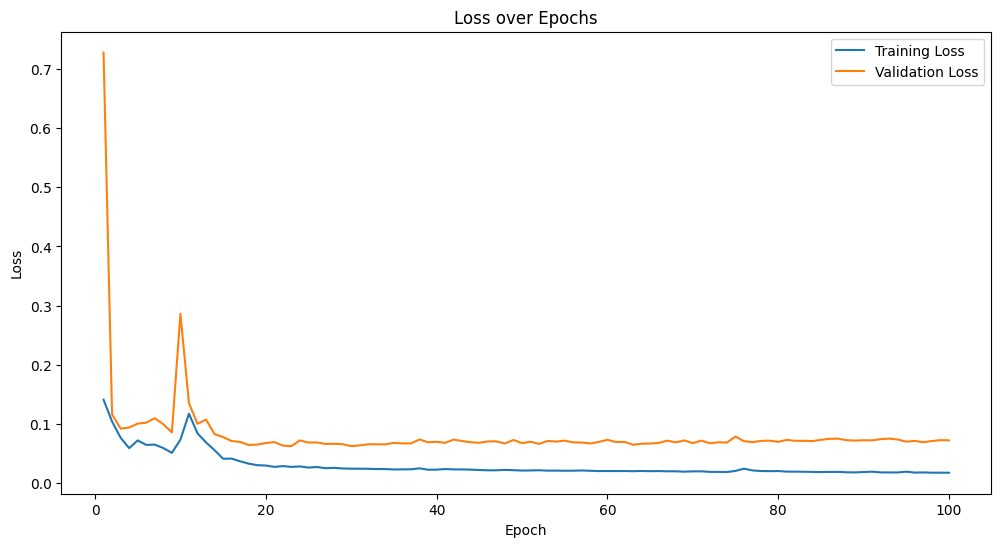

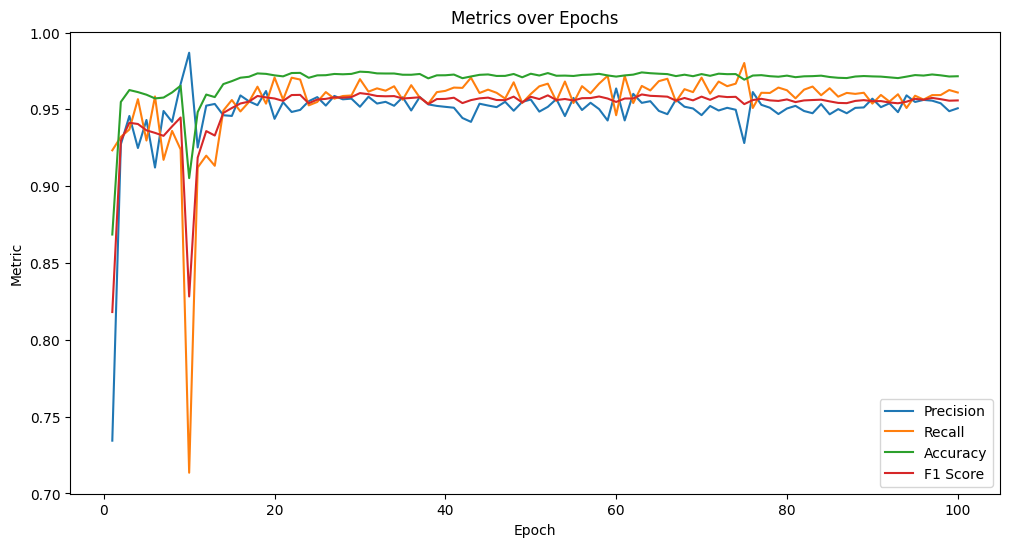

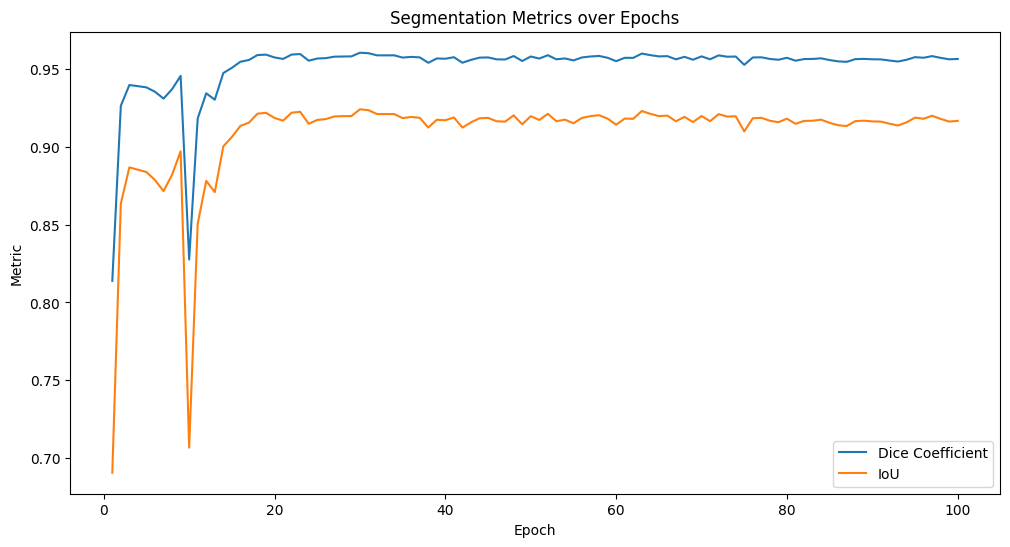

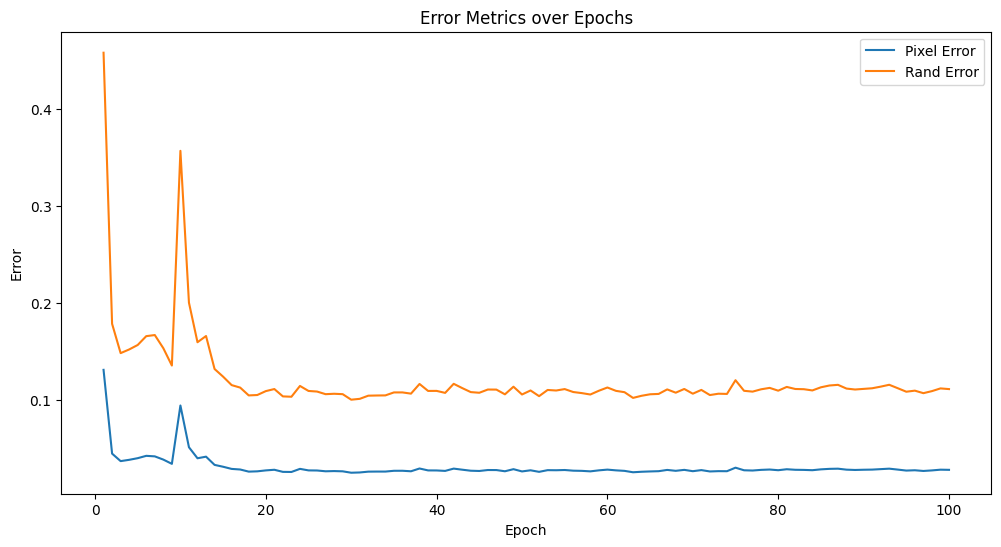

In [50]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



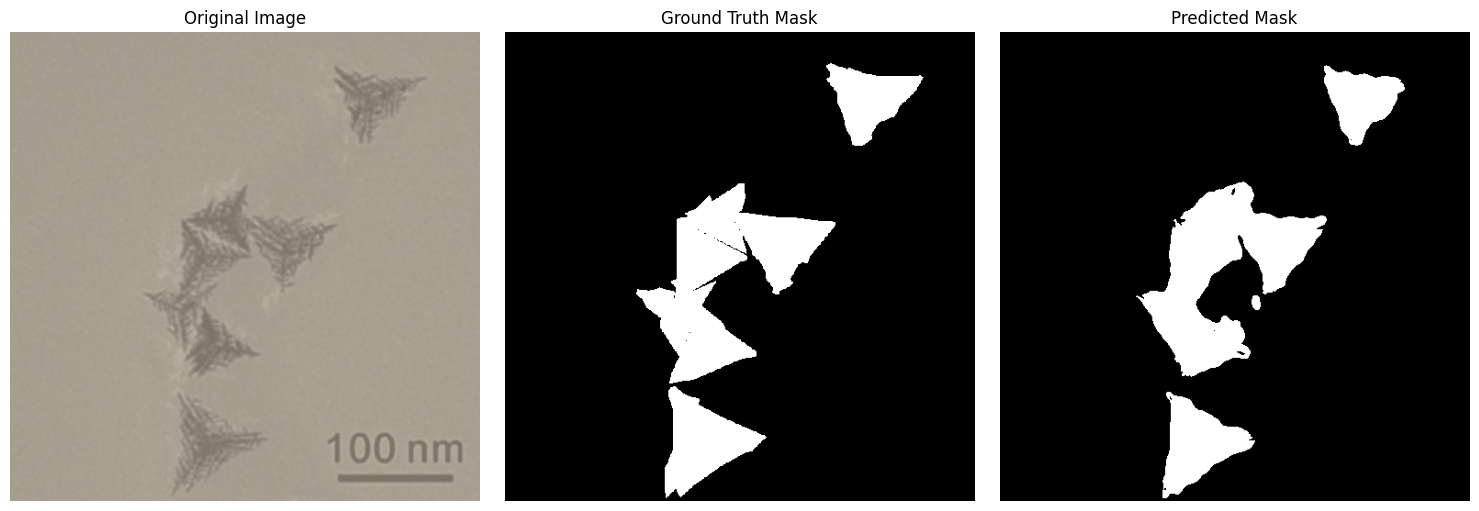

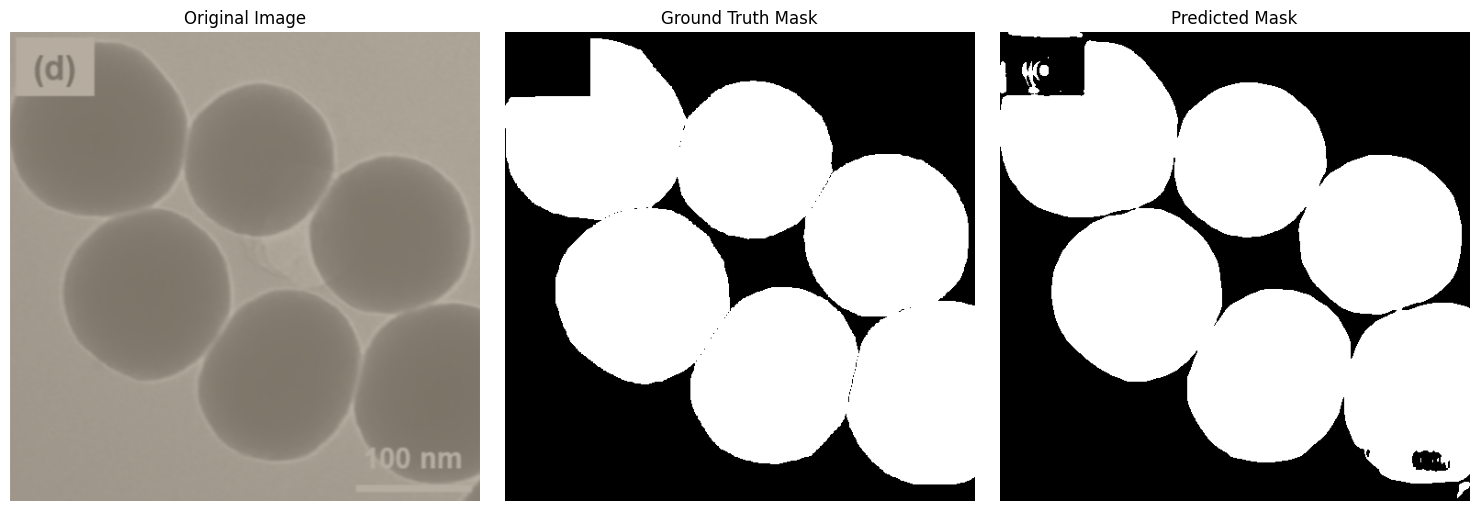

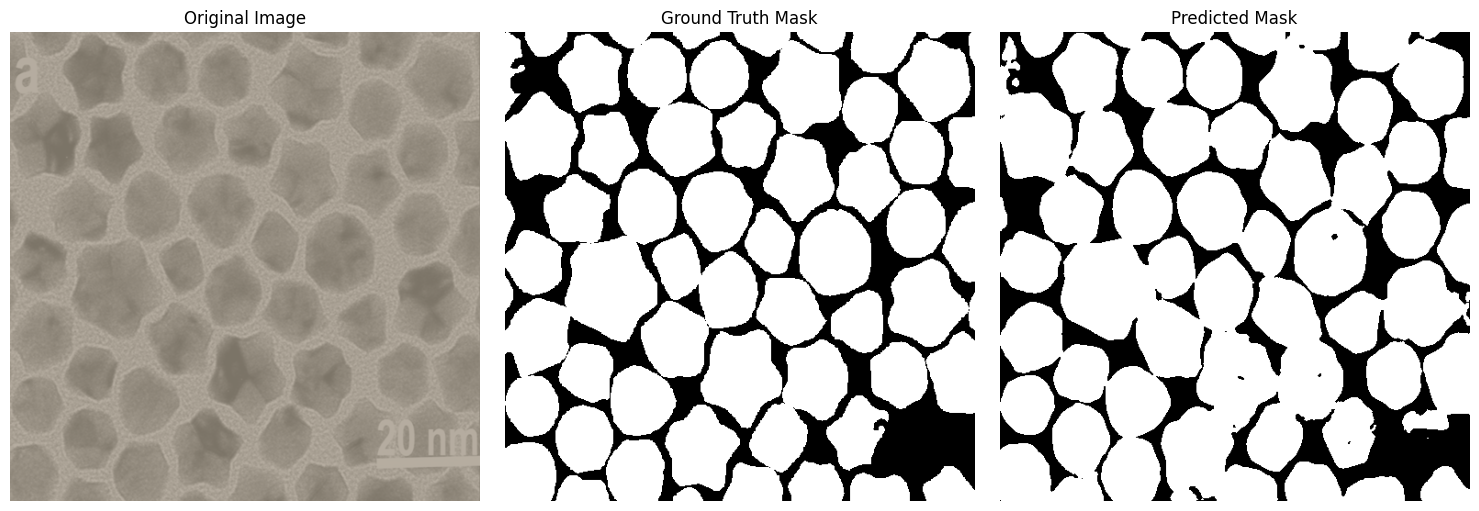

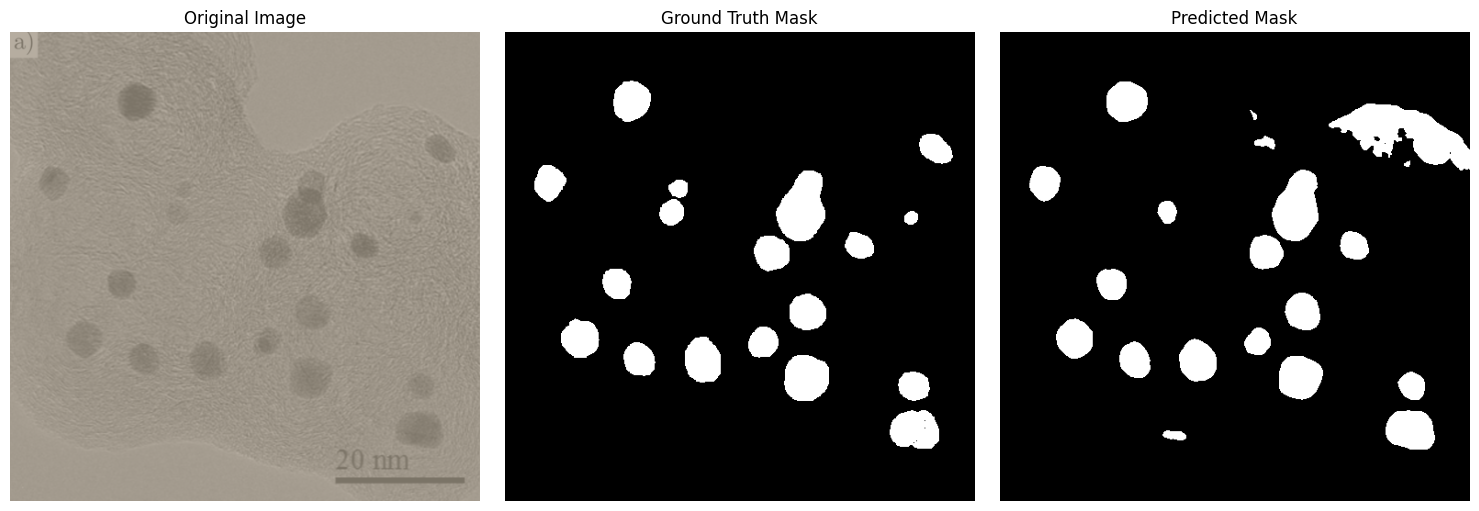

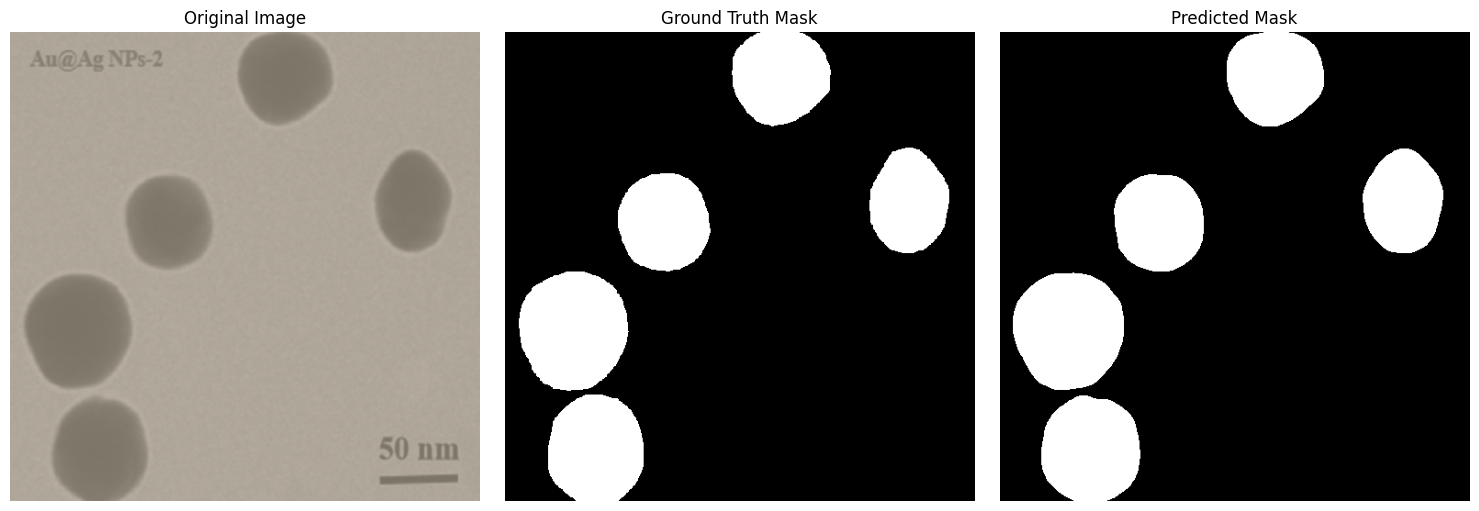

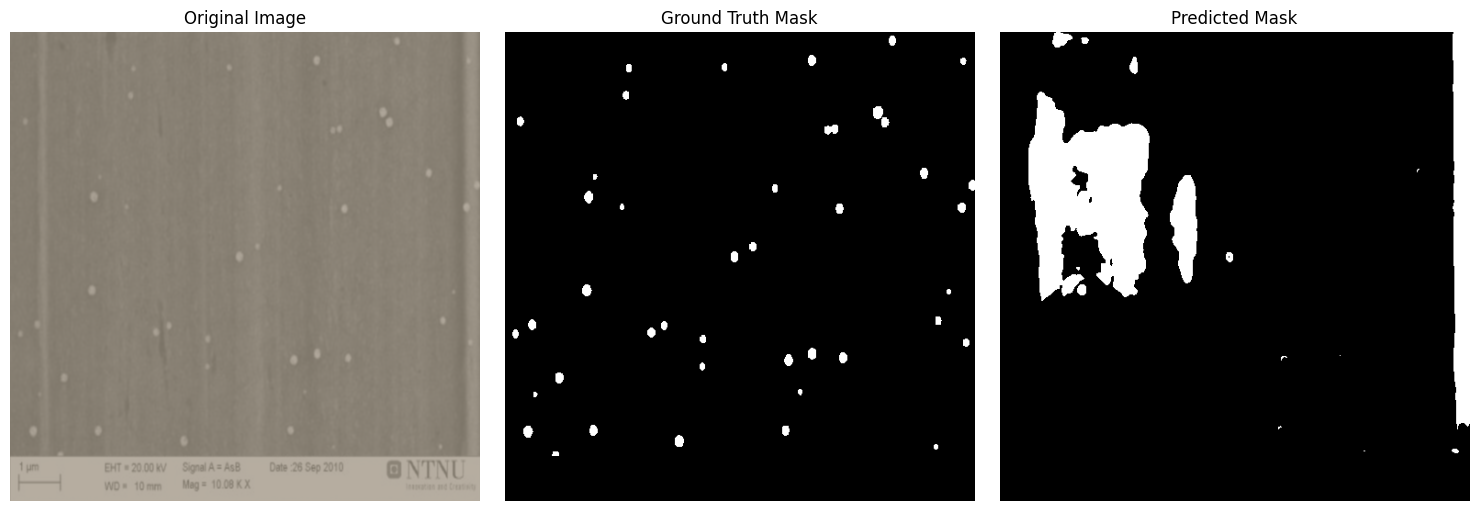

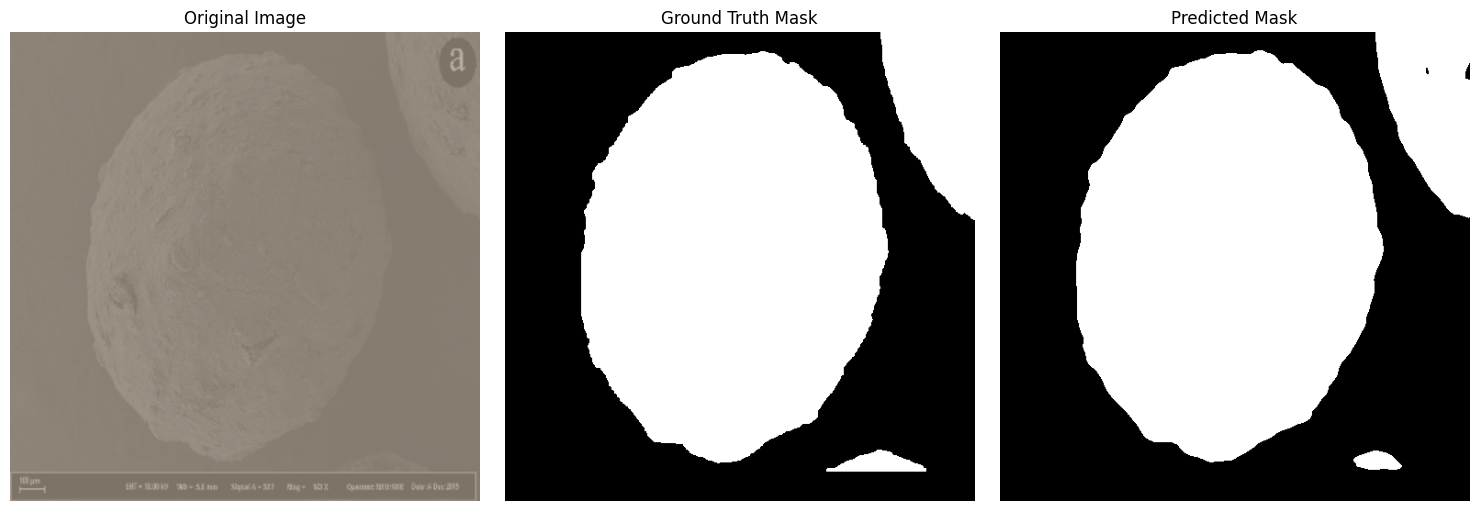

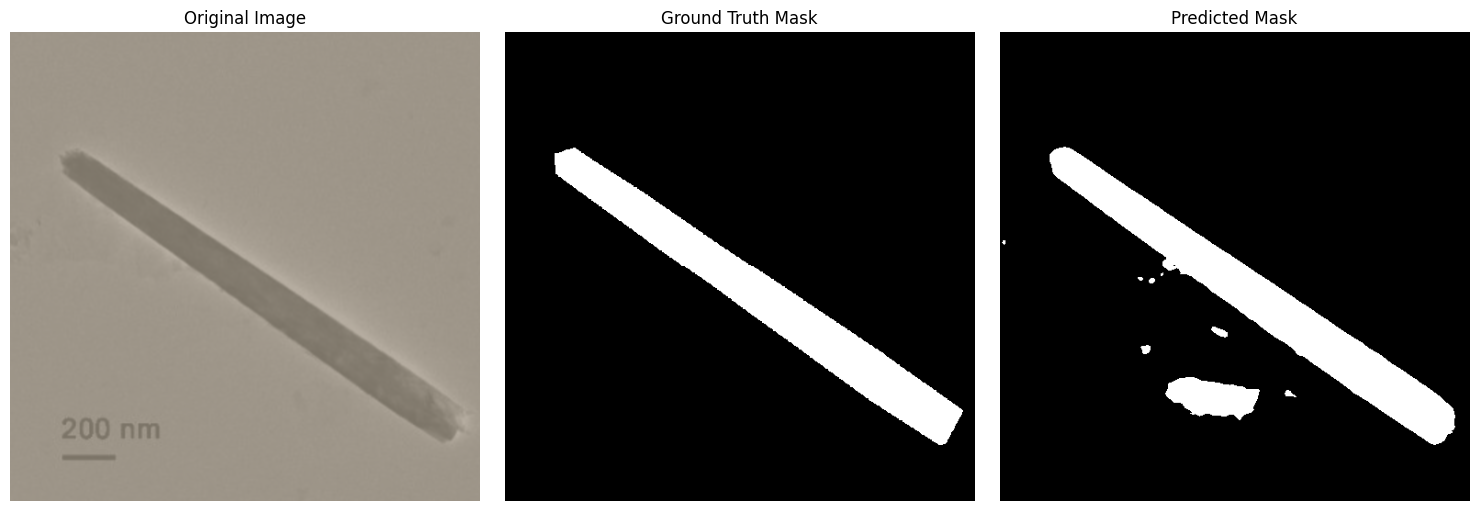

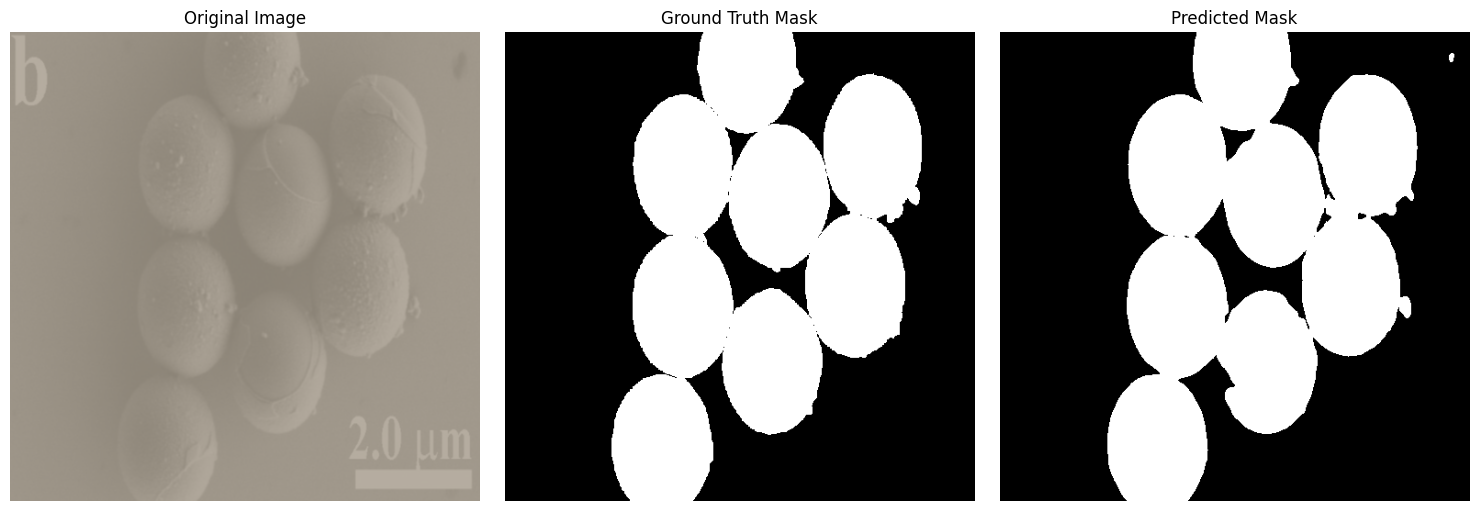

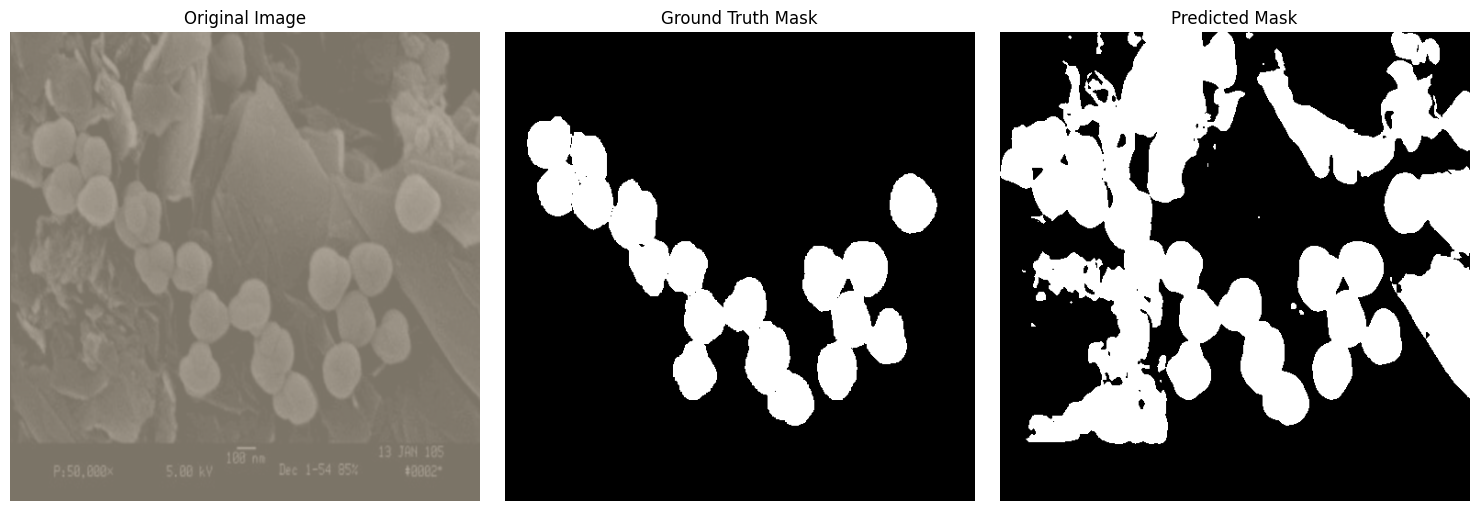

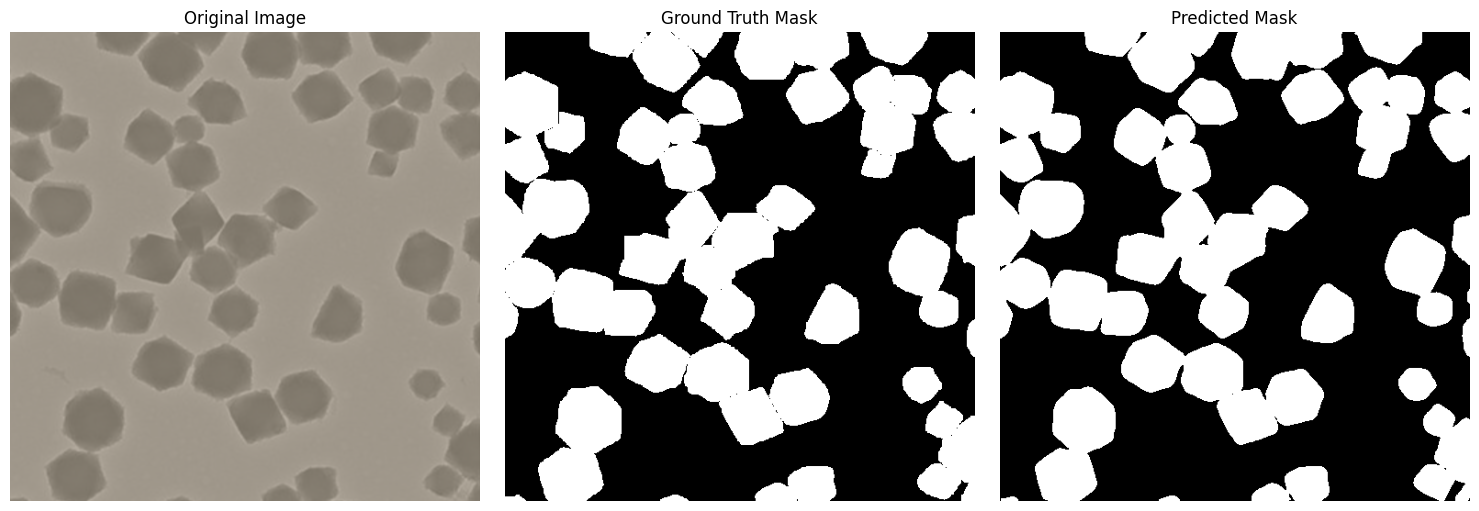

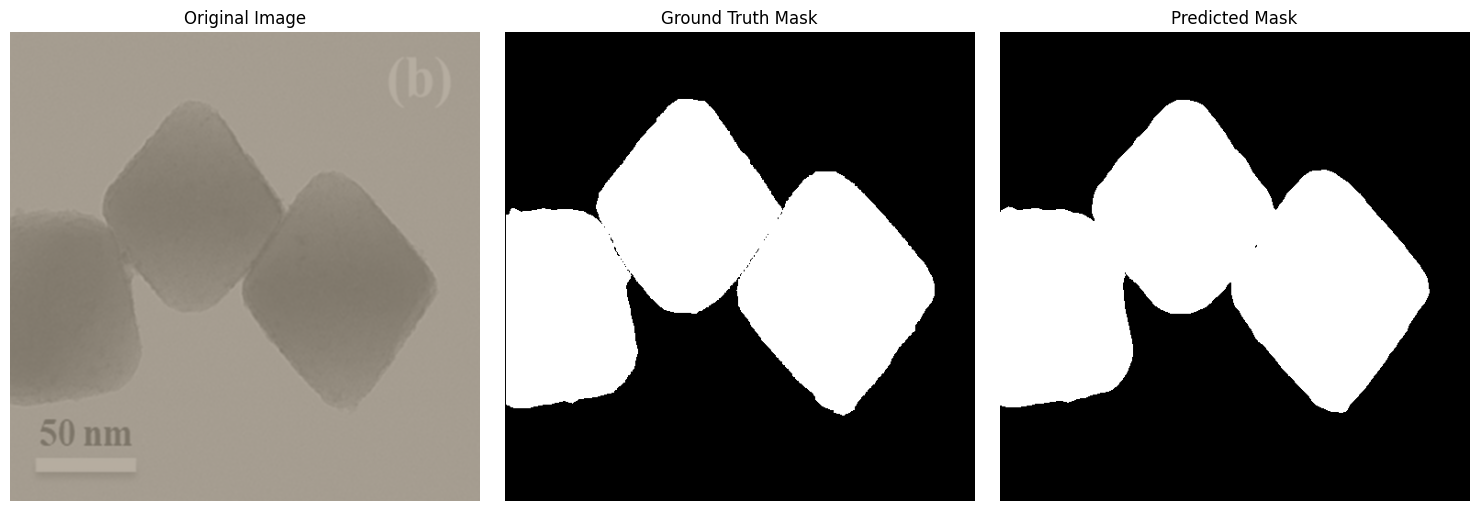

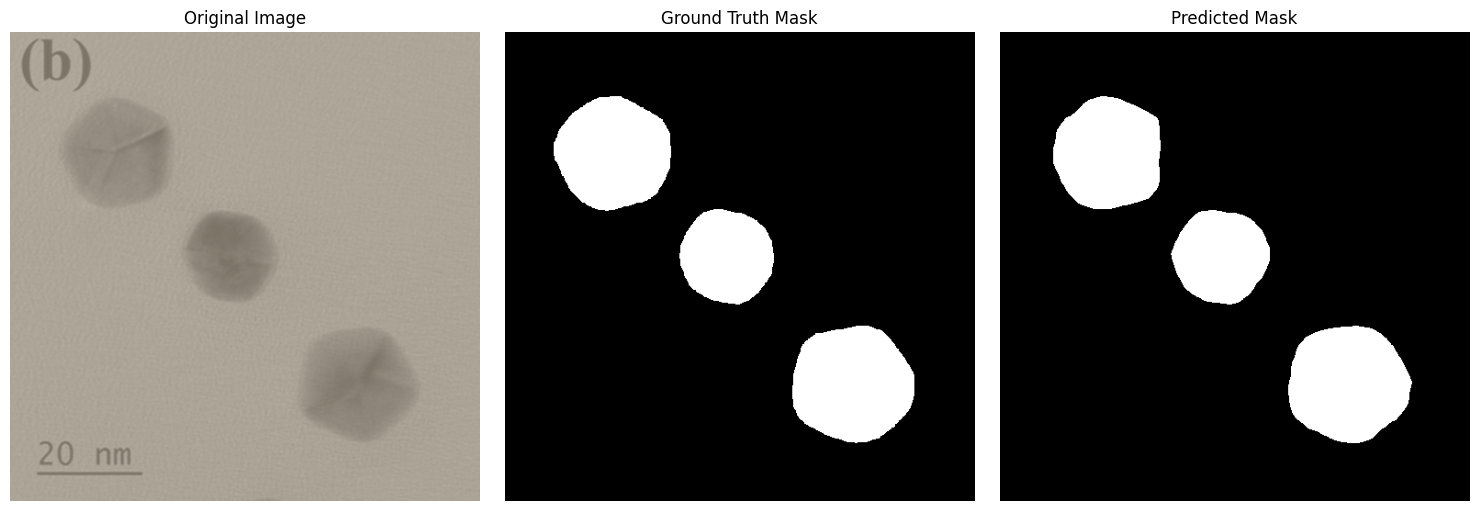

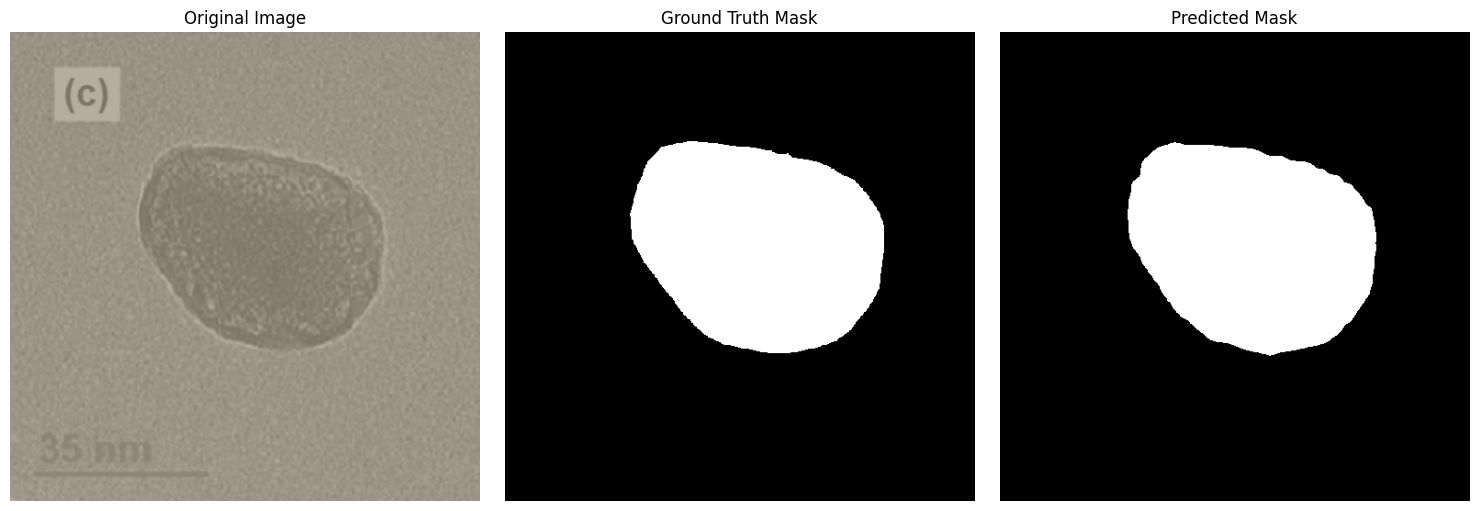

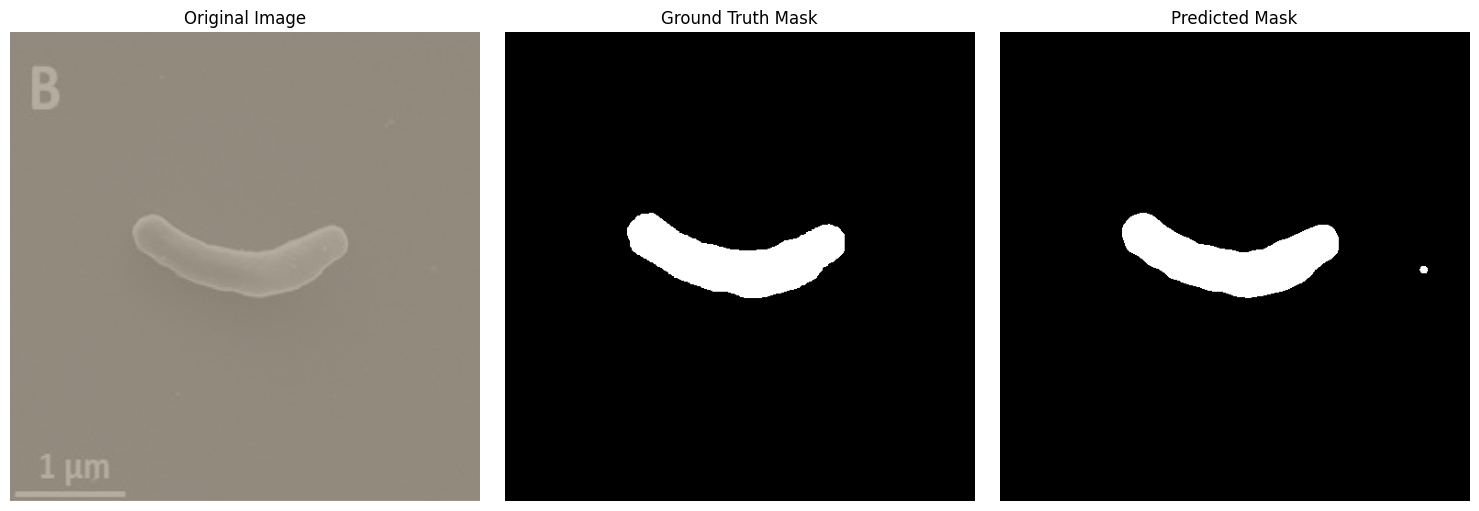

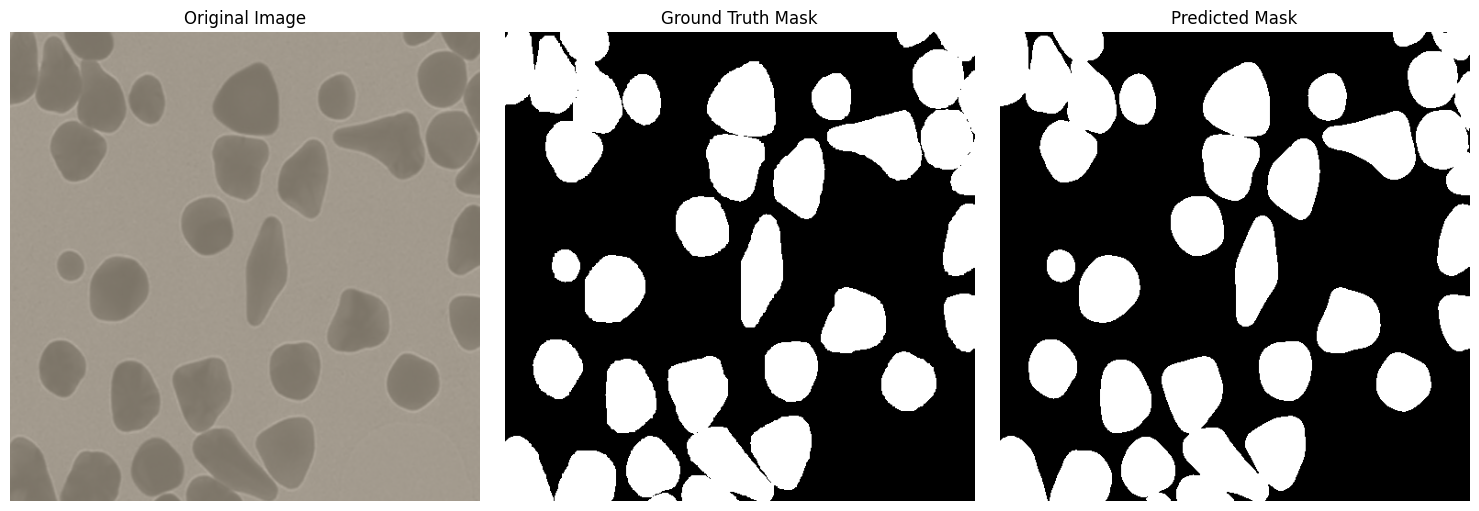

In [51]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    img = img * std + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [52]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy       iou  \
0       1    0.140919  0.727521   0.734387  0.923346  0.868549  0.690636   
1       2    0.103952  0.116112   0.927253  0.932073  0.954844  0.863520   
2       3    0.076658  0.091985   0.945702  0.936903  0.962579  0.886745   
3       4    0.059046  0.093980   0.924852  0.956648  0.961237  0.885243   
4       5    0.072147  0.100490   0.943107  0.929710  0.959543  0.883736   
..    ...         ...       ...        ...       ...       ...       ...   
95     96    0.017725  0.071225   0.956159  0.956378  0.971997  0.917964   
96     97    0.018023  0.069068   0.955667  0.959264  0.972713  0.919905   
97     98    0.017561  0.071089   0.953963  0.959308  0.972152  0.917866   
98     99    0.017547  0.072523   0.948811  0.962583  0.971396  0.916184   
99    100    0.017513  0.072233   0.950725  0.960970  0.971560  0.916626   

          f1  dice_coeff  rand_error  pixel_error  
0   0.818097    0.813881    0.45817